# TP3 - Classification par Lois Normales par approche Bayésienne

On désire écrire en python (avec pylab) un programme qui réalise la classification par lois normales (lois Gaussiennes) sur les données qui se trouvent dans l’embryon de programme loinormale.py. Le programme à écrire se compose : d’une partie qui réalise l’apprentissage des paramètres des lois et d’une partie qui réalise la classification d’un échantillon de test par rapport aux lois passées en paramètre. Vous disposez de 99 échantillons de chaque classe en dimension 2 pour réaliser l’apprentissage et d’un échantillon de chaque classe pour tester la classification.

In [36]:
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import numpy as np
from scipy.stats import norm
from numpy.linalg import inv, det
import math
from LoadData import *

In [37]:
def affichage_lois_normales(liste_donnees_classes, liste_parametres_classes):
    assert type(liste_donnees_classes) is list
    assert type(liste_parametres_classes) is list
    assert len(liste_donnees_classes)==len(liste_parametres_classes)

    nb_classes = len(liste_donnees_classes)
    couleurs= [ 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w' ]
    formespoints = [ 'x', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', '.', 'D', 'd', ',' ]
    formescentres = ['D','D','D']
    
    # Calcul des bornes
    x_ptnss = []
    y_ptnss = []
    for classe in range(nb_classes):
        for point in liste_donnees_classes[classe]:
            x_ptnss.append(point[0])
            y_ptnss.append(point[1])
            
    x_min, x_max = min(x_ptnss) - 1, max(x_ptnss) + 0.5
    y_min, y_max = min(y_ptnss) - 1, max(y_ptnss) + 0.5

    # plt.hold(True)
    for classe in range(nb_classes):
        # Affichage des points de la classe
        forme=formespoints[classe]
        couleur=couleurs[classe]
        stylepoint=forme+couleur
        for point in liste_donnees_classes[classe]:
            plt.plot(point[0],point[1],stylepoint, markersize=3)

        # Affichage des centroïdes
        forme=formescentres[classe]
        stylecentre=forme+'k'
        vecteur_moyenne = liste_parametres_classes[classe][0]
        plt.plot(vecteur_moyenne[0],vecteur_moyenne[1],stylecentre, markersize=2)

        # Affichage des courbes de niveaux
        cov_matrix = liste_parametres_classes[classe][1]
        step = 0.1
        x = np.arange(x_min, x_max, step)
        y = np.arange(y_min, y_max, step)
        X, Y = np.meshgrid(x, y)

        Z = mlab.bivariate_normal(X, Y, cov_matrix[0,0], cov_matrix[1,1], vecteur_moyenne[0], vecteur_moyenne[1], cov_matrix[0,1])
        plt.contour(X,Y,Z)

    plt.savefig('lois_normales.png')

    # plt.hold(False)

In [38]:
def affichage_histogramme_loinormale(data, label):
    # Affiche un historgramme d'une liste de valeur et superpose l'affichage de la loi normale associée
    plt.figure()
    n, bins, patches = plt.hist(data,30, normed=1, facecolor='green', alpha=0.75)
    y = norm.pdf( bins, np.mean(data), np.std(data))
    plt.plot(bins, y, 'r--', linewidth=1)
    plt.title(label)
    plt.show()

In [39]:
def affichage_point(point, classe=None):
    couleurs= [ 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w' ]
    formes = [ 'H', 'H', 'H' ]
    
    if classe is None:
        couleur = 'k'
    else: 
        couleur = couleurs[classe-1]
    style=couleur+'H'
    # plt.hold(True)
    plt.plot(point[0],point[1],style, markersize=7)
    # plt.hold(False)

In [40]:
def apprentissage_loi_normale(liste_donnees_classe):
    assert type(liste_donnees_classe) is list
    # apprentissage_loi_normale renvoie la liste des paramètres de la loi
    # normale correspondant aux données récupérées
    #
    # Entrée :
    # - liste_donnees_classe : liste de points (1 point = 1 vecteur de dimension 2) d'une classe
    # Sortie :
    # - liste_parametres : liste des paramètres
    #     element1 : centroïde (au format "array")
    #     element2 : matrice de covariance (au format "array")

    tab_donnees=np.array(liste_donnees_classe)
    
    # calcul du vecteur moyenne
    vect_moyenne = np.mean(tab_donnees, axis=0)

    # calcul de la matrice de covariance
    mat_covariance=np.cov(tab_donnees.T)

    return [vect_moyenne, mat_covariance]

In [41]:
def calcul_vraisemblance_loi_normale(donnee, liste_parametres, probas_a_priori=None, diagonalize=False):
    assert type(donnee) is list
    assert type(liste_parametres) is list

    # calcul de la log vraisemblance
    nb_classes = len(liste_parametres)
    vraisemblances = [0] * nb_classes
    for classe in range(nb_classes):
        p = liste_parametres[classe]
        cov_matrix = p[1]
        moy = p[0]
        if diagonalize:
            cov_matrix = diagonalize_matrix(cov_matrix)
            det_cov = my_det(cov_matrix)
            inv_cov = my_inv(cov_matrix)
        else:
            det_cov = det(cov_matrix)
            inv_cov = inv(cov_matrix)
        if det_cov != 0:
            vraisemblances[classe] = -math.log(det_cov) - (np.dot(np.dot((donnee-moy).T, inv_cov), (donnee-moy)))
        else:
            vraisemblances[classe] = 0
        if probas_a_priori is not None:
            vraisemblances[classe] += 2 * math.log(probas_a_priori[classe])

    classe_trouvee = np.argmax(vraisemblances)+1
    return [classe_trouvee, vraisemblances]

In [42]:
def diagonalize_matrix(cov_matrix):
    assert len(cov_matrix) == len(cov_matrix[0])
    
    ndim = len(cov_matrix)
    
    for i in range(ndim):
        for j in range(ndim):
            if i != j:
               cov_matrix[i][j] = 0
    
    return cov_matrix

In [43]:
def my_det(square_matrix):
    assert len(square_matrix) == len(square_matrix[0])
    prod = 1
    dim = len(square_matrix)
    for i in range(dim):
        for j in range(dim):
            if i==j:
                prod *= square_matrix[i][j]
                
    return prod

In [44]:
def my_inv(square_matrix):
    assert len(square_matrix) == len(square_matrix[0])
    dim = len(square_matrix)
    for i in range(dim):
        for j in range(dim):
            if i==j:
                square_matrix[i][j] = 1/square_matrix[i][j]
                
    return square_matrix

In [45]:
def print_diag(square_matrix):
    for i in range (len(square_matrix)):
        for j in range(len(square_matrix)):
            if i==j:
                print(square_matrix[i][j])

In [46]:
donnees_classe1 = [[0.94922183000000004, 0.30706191999999999], [0.13517493999999999, 0.51524634000000002], [0.26140632000000003, -0.94148577], [-0.16233766999999999, -0.14605462999999999], [-0.53201138000000003, 1.6821036], [-0.87572934999999996, -0.48381505000000002], [-0.71200454999999996, -1.1742123], [-0.19223952, -0.27407023000000003], [1.5300724999999999, -0.24902473999999999], [-1.0642134000000001, 1.6034573000000001], [1.2346790999999999, -0.22962645000000001], [-1.5061597, -0.44462782000000001], [-0.15594104, 0.27606825000000002], [-0.26116365000000002, 0.44342190999999997], [0.39189421000000002, -1.2506789], [-0.94796091999999998, -0.74110609000000005], [-0.50781754999999995, -0.32057551000000001], [0.012469041, -3.0291773000000002], [-0.45701464000000003, 1.2424484], [-1.0667013999999999, 0.93372816000000003], [0.35032099999999999, -0.029005764], [0.18245217, -1.565056], [-0.08453948, 1.6039464000000001], [0.098347774999999998, 0.041373612999999997], [-0.73416910999999996, -0.030813730000000001], [0.23234700999999999, 0.42638756], [-0.37280874000000003, -0.23645458], [2.0236909000000001, -2.2583540000000002], [2.2294456999999999, 0.33756370000000002], [1.0000608, -1.6641645], [-0.59003455999999999, -0.27806416], [0.42271568999999998, -1.6702007000000001], [0.47163432999999999, -1.2128471999999999], [0.066190048000000001, 0.65235589000000005], [0.32705996999999998, 1.0826335], [1.0060770999999999, -0.65090773999999996], [0.25705615999999998, -0.94437780999999998], [-1.3217885, 0.92482593000000002], [4.9849075000000002e-05, -0.054918914999999999], [0.91112727000000004, 0.59458370000000005], [0.35020117000000001, 1.2502511999999999], [0.92978945999999996, 0.23976326000000001], [-0.69036109999999995, -0.65155364000000004], [1.1921018999999999, -1.6118304000000001], [-0.024461937, -1.9488471999999999], [1.0204979999999999, 0.86171629999999999], [0.0011620834999999999, -0.070837212999999996], [-2.4862839000000001, 0.58117231999999996], [-2.1924348999999999, -2.3192803], [0.079933710000000005, -0.94848098000000003], [0.41149061999999997, 0.67697781000000001], [0.85773255000000004, -0.69115912999999995], [0.44937761999999998, 0.10063335], [0.82606999999999997, 0.53615707999999995], [0.89788842999999996, -0.13193787000000001], [-0.14720146000000001, 1.0077734], [-2.1236554999999999, -0.50458641000000004], [-1.2705944, -0.3825848], [0.64867925999999998, 0.82572714999999997], [-1.0149436000000001, -0.47106990999999998], [0.13702486999999999, -0.29186338000000001], [0.30181856000000001, 0.39993094000000001], [-0.92996155999999996, -0.17683027000000001], [-2.1320945999999998, 1.1453617], [-0.62909075999999997, -1.2038500000000001], [-0.25394467999999998, -1.4286468999999999], [-0.020857618000000001, -0.56066499999999997], [2.1777787000000002, 1.1384654000000001], [-2.4968865, 0.44132693000000001], [-1.3981379, -0.25505517999999999], [0.16440407000000001, 0.74773403000000005], [-0.27304695000000001, 1.5763001000000001], [-0.48093714999999998, 0.32751212000000002], [0.66473411999999998, 0.085188593000000007], [0.88095279000000004, 0.32321314000000001], [-0.78414618000000003, -1.8053733999999999], [1.8585929000000001, -0.60453009000000002], [0.10335972, 0.56316695999999999], [0.113597, -0.90472620999999998], [-0.46771457999999999, -0.12488995], [1.4789585000000001, -0.86081569000000002], [0.78466846999999995, 0.30862314000000002], [-0.23386003999999999, -1.0569727], [-0.28414095, -0.086690281999999994], [-1.4693951000000001, 0.19218224], [-0.82229328000000002, -0.094240588], [0.33621334000000003, -0.90465406000000004], [-0.28825635999999999, 0.35006275999999997], [-1.8358591, 1.0359758999999999], [2.4244610999999998, 0.95940051000000004], [-0.315772, 0.42862267999999998], [-1.0359848, 1.8778655], [0.9407044, 0.78734578], [-0.87587426000000002, 0.31994913000000003], [-0.55829428000000003, -0.31142942000000001], [-0.57000991999999995, -1.0257335999999999], [-0.90874558999999999, -0.20989732999999999], [-1.6988641, 0.60760057999999995], [-0.11779829, 0.69916033]]
donnees_classe2 = [[0.74115313999999999, 3.8621732999999998], [3.3187652000000001, 1.6923117000000001], [2.566408, 3.3426244999999999], [6.5783969000000004, 5.7694369999999999], [1.6501131, 6.0349234999999997], [3.7254041999999998, 2.9369451], [3.7147429000000001, 2.7950339], [2.8758556999999998, 4.4896976000000004], [4.4090344999999997, 4.4171924000000002], [3.6714970999999998, 1.7925131000000001], [3.7172386999999998, 4.6302352999999998], [3.4888938, 4.0346929999999999], [3.7268851000000001, 2.6965591], [3.2938714999999998, 2.2127172000000002], [3.8883956, 1.8529298999999999], [1.9311294999999999, 2.1905013000000002], [0.055715837999999997, 4.4383803000000004], [3.3251905000000002, 2.2450717], [4.3702984999999996, 1.2884836], [2.8977575999999998, 2.758553], [3.3192067000000001, 3.3128586000000002], [2.1351201, 2.9699487000000002], [2.835121, 3.6277073], [4.0932656999999999, 4.1092732999999999], [2.1363471999999999, 3.0773590999999998], [1.7858830000000001, 1.8864993000000001], [2.9931507000000002, 4.5326303000000001], [2.2303340999999999, 3.3713788], [2.7744156000000002, 4.1173561000000003], [1.9109357, 3.0325574999999998], [3.552527, 4.1006102000000002], [4.5442118999999996, 3.0859310999999998], [1.5084097000000001, 2.2576982000000001], [1.9384182999999999, 5.3504572000000001], [2.3843980999999999, 3.7480768000000002], [2.8075815, 3.8886104000000001], [2.2351508, 1.597731], [1.5776241, 3.4881939000000002], [2.8226247999999998, 2.8039464999999999], [4.4193102, 3.2915844000000001], [3.1978111, 4.5876991], [2.1955339999999999, 3.6966244000000001], [3.8350881999999999, 2.7562848999999998], [3.2156701000000001, 1.8341561], [1.8520471999999999, 3.1048746999999999], [3.722254, 5.5854913000000002], [2.3331092999999998, 3.1873309999999999], [2.9175056000000001, 1.0669770999999999], [2.5610338000000001, 1.2053212], [3.8403754999999999, 2.1119678999999998], [3.1000928000000001, 2.4554711], [3.3035207999999998, 2.3996734000000002], [3.4899653000000002, 3.7393630999999998], [4.7118878000000004, 2.8058765000000001], [0.86164472999999997, 2.1604112999999998], [4.3545942999999996, 1.9278447000000001], [3.9609538999999998, 3.1240497999999999], [4.4366966000000003, 1.0390999999999999], [2.8023018, 1.7921545000000001], [5.9080079999999997, 3.8252188999999999], [4.3789720000000001, 1.9418196999999999], [2.5313843999999999, 2.7275306000000001], [4.0984246000000004, 2.7221280999999999], [3.7015414999999998, 0.94818369999999996], [2.64615, 2.1764134999999998], [1.4229430000000001, 3.5079747000000001], [3.2819840999999998, 3.0334799000000001], [1.6663220999999999, 4.1274923000000001], [3.3501794, 2.7009340000000002], [3.0228898000000002, 2.7380046], [1.2497876000000001, 2.7143489999999999], [2.1686334999999999, 2.0207937], [1.8435983, 2.4664429000000001], [0.99736426, 3.9642293999999998], [3.5200600999999998, 2.9799720999999999], [2.9652289000000001, 2.2018363999999999], [4.0186852999999996, 2.8667824999999998], [2.2854698, 4.3513858000000001], [2.7752289000000001, 2.410971], [2.7062463999999999, 2.1520738000000001], [1.8798717, 5.5259996999999998], [4.6554976000000003, 3.3075351999999998], [1.7428816, 2.1345320000000001], [2.8234659, 3.7914161000000002], [1.6679956, 0.67013283999999995], [1.5509027, 3.3335108], [3.3913536, 3.4516794000000002], [2.8697153000000002, 3.1836891], [2.523847, 3.8620215999999998], [1.6383055, 3.4550296], [2.1512905999999998, 2.6651131000000001], [3.5527833000000002, 4.0390907], [1.8823612999999999, 4.2606586999999996], [3.6601431, 2.9321343999999998], [2.8047787999999998, 2.7823935999999998], [2.6968923999999999, 3.0230456000000001], [3.0512904000000001, 3.8260627999999999], [4.5269766999999996, 3.4669143999999998], [2.7902866999999998, 3.6251904000000001]]
donnees_classe3 = [[1.5168790000000001, -1.0202644000000001], [2.5530050000000002, 0.10965859], [4.1287364999999996, -0.28996304000000001], [4.2615506999999999, 0.47542480999999998], [4.1741168000000002, 0.12694707], [2.3431841000000002, -1.4813991], [3.1554890000000002, 0.81855137], [2.7074118999999999, -0.54078641999999999], [2.6913581999999998, -1.0965933000000001], [2.5069902000000002, -0.18073935999999999], [3.0458411000000001, -0.063783119999999999], [3.6113352000000001, 0.10931769], [4.8140155, 0.31202383], [4.8044938000000004, -0.72312147999999998], [3.5265469999999999, -0.26025085999999997], [3.6001425, 0.59393079999999998], [0.81397839000000005, -1.3270431], [1.5589864, 0.40184449999999999], [4.4702013000000003, -0.32681422999999998], [3.8123230000000001, 0.54554009999999997], [1.9483676999999999, 0.39746700000000001], [2.2481053000000002, 1.5162669], [2.9674334999999998, 1.6359996999999999], [2.5749415, 0.58943336999999996], [2.9372088000000001, -2.0219589], [2.0178685000000001, 0.61251129999999998], [2.9451139, -1.1187320000000001], [2.3736215000000001, 0.24951773999999999], [2.0069810000000001, 0.97495021999999998], [2.3592905000000002, 1.8088626000000001], [1.9201337000000001, 0.19918944], [1.4789734000000001, -0.72363113000000001], [2.4067497000000002, 0.40133634000000001], [3.9421333000000001, 0.30048596999999999], [2.6269293, 0.81548851], [3.7988870000000001, 0.12020528], [3.5712476, 0.41279600999999999], [2.0130381000000002, 0.75956833000000001], [2.3427986999999999, -0.60391848000000004], [3.1769468000000001, -0.30750347], [2.8681795999999999, 0.59535766999999995], [4.0468327999999998, -0.19795863], [3.3276781999999998, -0.2383015], [3.2295969000000002, 0.4399979], [2.3831340999999999, 0.27483679], [3.601102, 0.092307950999999999], [4.7298413999999998, -0.60855744000000001], [2.2629402000000001, -1.7498792999999999], [3.9104825999999999, 0.86708255000000001], [2.9201071999999999, 0.89847599], [3.1837034000000002, 0.29079012999999998], [3.1129446999999999, 0.43995219000000002], [3.1016623999999999, 2.7873351999999998], [1.8333349999999999, -1.8542991], [1.8593189000000001, -1.0933435], [2.5663906999999999, -0.16846987999999999], [2.7814663999999998, 0.54133443999999997], [3.3892661999999998, 0.75122898000000005], [4.7782558999999996, 1.2230626], [1.7167439, -2.3289545], [3.9019314999999999, -1.8356387000000001], [3.0667569000000001, 0.035479485999999998], [5.2271681000000001, -0.069214254000000003], [2.4926769000000002, 0.23580967], [3.2458049, 0.070045208999999997], [2.3914195, -1.2225934000000001], [3.3165003999999998, -1.3428692], [1.9678157000000001, 1.3312158999999999], [2.5810968000000001, -0.14032172000000001], [3.8998222999999999, -0.30011101000000001], [4.0293656999999996, -0.34506597], [4.0128019000000004, 0.62933457999999998], [2.7869849000000002, -0.86569731000000005], [1.9568916999999999, -0.27006880999999999], [2.5618585999999999, -0.40867430999999999], [3.9835452, -0.29769714000000003], [4.1436789000000003, -0.53162012000000003], [3.9725657000000001, -0.52225047999999996], [3.1765778, 0.97073781999999997], [2.5860276999999998, -0.43827052], [5.0033906000000004, 0.95099350000000005], [2.5679962000000001, 0.64894074000000002], [2.6399237000000002, 0.70588501999999997], [4.4158491, -1.6045157000000001], [4.0288531000000001, 1.4579678], [3.0474713000000002, 1.7462567], [3.1553874999999998, -1.2371197], [0.80650571999999998, -0.33340707000000003], [3.7135433, 0.31740773], [3.4136104, -0.57708557999999999], [3.1440017999999998, -1.6386657], [2.2399100000000001, -0.81879310000000005], [3.5197289, -0.014160058999999999], [1.8444706, -0.0095249160999999992], [2.3101894999999999, -0.66669915000000002], [3.8641494000000001, 0.11341944], [3.3983628000000001, 0.88396989000000004], [3.1802576999999999, 0.55085452000000001], [3.6829643000000001, 1.1706087000000001]]
liste_donnees_classes = [donnees_classe1,donnees_classe2,donnees_classe3]

## Question 1 : affichage de l'histogramme

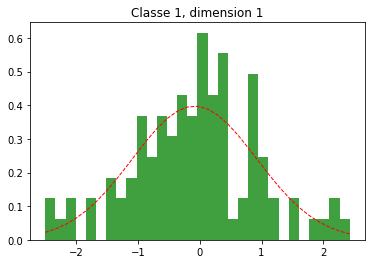

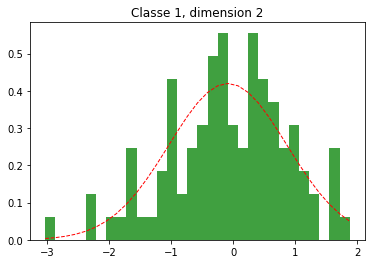

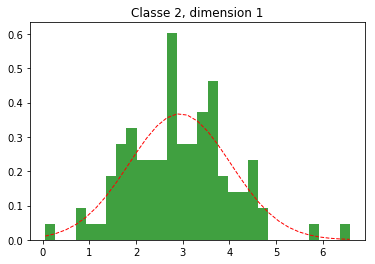

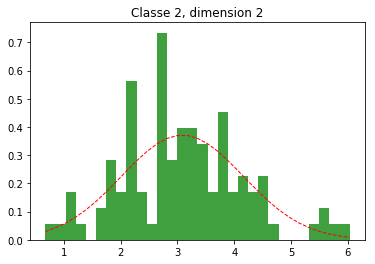

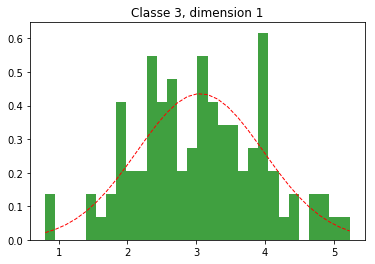

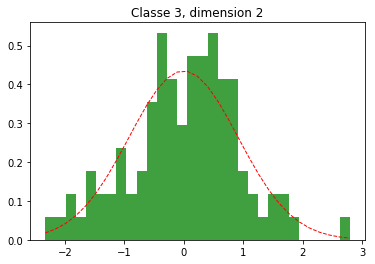

In [47]:
nb_dim = len(liste_donnees_classes[0][0])
nb_classes = len(liste_donnees_classes)
for i in range(nb_classes):
    for j in range(nb_dim):
        data = np.array(liste_donnees_classes[i])
        dim = data[:,j]
        affichage_histogramme_loinormale(dim, "Classe {}, dimension {}".format(i+1, j+1))

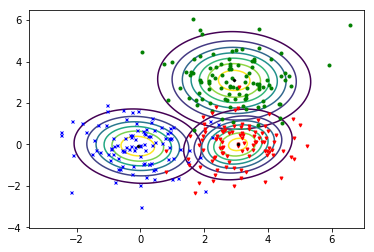

In [48]:
# Question 2 : voir dans la fonction apprentissage_loi_normale
liste_parametres_classe1 = apprentissage_loi_normale(donnees_classe1)
liste_parametres_classe2 = apprentissage_loi_normale(donnees_classe2)
liste_parametres_classe3 = apprentissage_loi_normale(donnees_classe3)

liste_parametres_classes = [liste_parametres_classe1, liste_parametres_classe2, liste_parametres_classe3]

donnee_test_classe1 = [0.18322726, -1.0297674999999999]
donnee_test_classe2 = [3.5376671000000002, 4.8338850000000004]
donnee_test_classe3 = [3.2696486, 0.49428706]

plt.figure()
affichage_lois_normales(liste_donnees_classes,liste_parametres_classes)
plt.show()

La donnee de classe 1 a ete reconnue comme une donnee de classe  1
Vraisemblances :  [-0.9346349488137533, -21.89467440787051, -9.877838751971575]
La donnee de classe 2 a ete reconnue comme une donnee de classe  2
Vraisemblances :  [-42.24453828611732, -3.302712791479173, -27.220929179739468]
La donnee de classe 3 a ete reconnue comme une donnee de classe  3
Vraisemblances :  [-11.698487597238884, -6.13133117635699, 0.027379106581800594]


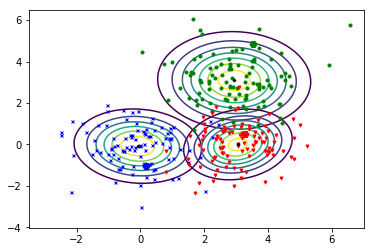

In [49]:
# Question 3 : voir dans la fonction calcul_vraisemblance_loi_normale

plt.figure()
affichage_lois_normales(liste_donnees_classes,liste_parametres_classes)

[classe_trouvee,liste_vraisemblances] = calcul_vraisemblance_loi_normale(donnee_test_classe1,liste_parametres_classes)
print( "La donnee de classe 1 a ete reconnue comme une donnee de classe ",int(classe_trouvee))
print( "Vraisemblances : ",list(liste_vraisemblances))
affichage_point(donnee_test_classe1, classe=classe_trouvee)

[classe_trouvee,liste_vraisemblances] = calcul_vraisemblance_loi_normale(donnee_test_classe2,liste_parametres_classes)
print( "La donnee de classe 2 a ete reconnue comme une donnee de classe ",int(classe_trouvee))
print( "Vraisemblances : ",list(liste_vraisemblances))
affichage_point(donnee_test_classe2, classe=classe_trouvee)

[classe_trouvee,liste_vraisemblances] = calcul_vraisemblance_loi_normale(donnee_test_classe3,liste_parametres_classes)
print( "La donnee de classe 3 a ete reconnue comme une donnee de classe ",int(classe_trouvee))
print( "Vraisemblances : ",list(liste_vraisemblances))
affichage_point(donnee_test_classe3, classe=classe_trouvee)

plt.show()

La donnee de classe 1 a ete reconnue comme une donnee de classe  1
Vraisemblances :  [-3.131859526149973, -22.735831899706938, -19.088179123947757]
La donnee de classe 2 a ete reconnue comme une donnee de classe  2
Vraisemblances :  [-44.44176286345354, -4.143870283315598, -36.43126955171565]
La donnee de classe 3 a ete reconnue comme une donnee de classe  2
Vraisemblances :  [-13.895712174575104, -6.9724886681934155, -9.18296126539438]


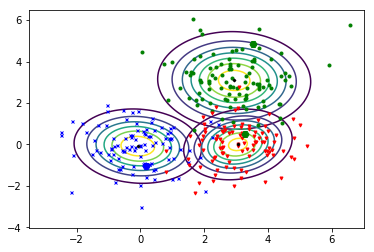

In [50]:
# Question 4

probas_a_priori = [1/3, 2/3-0.01, 0.01]

plt.figure()
affichage_lois_normales(liste_donnees_classes,liste_parametres_classes)

[classe_trouvee,liste_vraisemblances] = calcul_vraisemblance_loi_normale(donnee_test_classe1,liste_parametres_classes, probas_a_priori=probas_a_priori)
print( "La donnee de classe 1 a ete reconnue comme une donnee de classe ",int(classe_trouvee))
print( "Vraisemblances : ",list(liste_vraisemblances))
affichage_point(donnee_test_classe1, classe=classe_trouvee)

[classe_trouvee,liste_vraisemblances] = calcul_vraisemblance_loi_normale(donnee_test_classe2,liste_parametres_classes, probas_a_priori=probas_a_priori)
print( "La donnee de classe 2 a ete reconnue comme une donnee de classe ",int(classe_trouvee))
print( "Vraisemblances : ",list(liste_vraisemblances))
affichage_point(donnee_test_classe2, classe=classe_trouvee)

[classe_trouvee,liste_vraisemblances] = calcul_vraisemblance_loi_normale(donnee_test_classe3,liste_parametres_classes, probas_a_priori=probas_a_priori)
print( "La donnee de classe 3 a ete reconnue comme une donnee de classe ",int(classe_trouvee))
print( "Vraisemblances : ",list(liste_vraisemblances))
affichage_point(donnee_test_classe3, classe=classe_trouvee)

plt.show()

In [51]:
# Question 5 : Généralisation test avec les données IRIS
dataFilename = 'data/iris.data'
groundtruthFilename = 'data/iris.ground'

data_iris = loadPoints(dataFilename)
groundtruth_iris = loadClusters(groundtruthFilename)

nb_classes = 3
diagonalize = False
liste_donnees_classes = build_classes_array(data_iris, groundtruth_iris, nb_classes)

liste_parametres_classe1 = apprentissage_loi_normale(liste_donnees_classes[0])
liste_parametres_classe2 = apprentissage_loi_normale(liste_donnees_classes[1])
liste_parametres_classe3 = apprentissage_loi_normale(liste_donnees_classes[2])

liste_parametres_classes = [liste_parametres_classe1, liste_parametres_classe2, liste_parametres_classe3]

donnee_test_iris_c1 = [4.7, 3.5, 2., 0.5]
donnee_test_iris_c2 = [5.2, 2.5, 4.2, 1.4]
donnee_test_iris_c3 = [7.5, 2.7, 6., 2.]

[classe_trouvee,liste_vraisemblances] = calcul_vraisemblance_loi_normale(donnee_test_iris_c1,liste_parametres_classes, diagonalize=diagonalize)
print( "La donnee de classe 1 a ete reconnue comme une donnee de classe ",int(classe_trouvee))
print( "Vraisemblances : ",list(liste_vraisemblances))

[classe_trouvee,liste_vraisemblances] = calcul_vraisemblance_loi_normale(donnee_test_iris_c2,liste_parametres_classes, diagonalize=diagonalize)
print( "La donnee de classe 2 a ete reconnue comme une donnee de classe ",int(classe_trouvee))
print( "Vraisemblances : ",list(liste_vraisemblances))

[classe_trouvee,liste_vraisemblances] = calcul_vraisemblance_loi_normale(donnee_test_iris_c3,liste_parametres_classes, diagonalize=diagonalize)
print( "La donnee de classe 3 a ete reconnue comme une donnee de classe ",int(classe_trouvee))
print( "Vraisemblances : ",list(liste_vraisemblances))

La donnee de classe 1 a ete reconnue comme une donnee de classe  1
Vraisemblances :  [-4.6904531450392035, -62.351739886592625, -108.89507017925972]
La donnee de classe 2 a ete reconnue comme une donnee de classe  2
Vraisemblances :  [-323.65276833391124, 5.581049448558864, 0.3545986662845255]
La donnee de classe 3 a ete reconnue comme une donnee de classe  3
Vraisemblances :  [-875.8717507500892, -17.63170186892179, 3.078814842925751]


In [52]:
# Question 6 : High dimentional dataset

dataFilename = 'data/abalone_formated.data'
groundtruthFilename = 'data/abalone_formated.ground'
testFilename = 'data/abalone_formated.test'

data = loadPoints(dataFilename)
groundtruth = loadClusters(groundtruthFilename)
test_data = loadPoints(testFilename)


nb_classes = 3
nb_data = len(test_data)
diagonalize = False
liste_donnees_classes = build_classes_array(data, groundtruth, nb_classes)

#Apprentissage
liste_parametres_classe1 = apprentissage_loi_normale(liste_donnees_classes[0])
liste_parametres_classe2 = apprentissage_loi_normale(liste_donnees_classes[1])
liste_parametres_classe3 = apprentissage_loi_normale(liste_donnees_classes[2])
liste_parametres_classes = [liste_parametres_classe1, liste_parametres_classe2, liste_parametres_classe3]

print("Apprentissage terminé")

#Test
for i in range(nb_data):
    [classe_trouvee,liste_vraisemblances] = calcul_vraisemblance_loi_normale(test_data[i], liste_parametres_classes, diagonalize=diagonalize)
    print("La donnee {} a ete reconnue comme une donnee de classe {}".format(i, int(classe_trouvee)))
    print("Vraissemblance: {}".format(liste_vraisemblances))

Apprentissage terminé
La donnee 0 a ete reconnue comme une donnee de classe 2
Vraissemblance: [33.178382596941624, 34.06389426237742, 19.295130705391706]
La donnee 1 a ete reconnue comme une donnee de classe 2
Vraissemblance: [38.0675703343545, 38.28874097801642, 30.138615230393754]
